/tmp/ipython-input-4127347840.py:215: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz = TwoLocal(


--- VQE Optimization Started (18 params) ---
Exact Ground State E0 (from diagonalization): -0.303389


/tmp/ipython-input-4127347840.py:97: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  current_energy = cost(xk)
/tmp/ipython-input-4127347840.py:97: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  current_energy = cost(xk)


VQE Optimal Energy (E0): -0.202153
Optimization Success: True

--- Renyi Entropy Calculation (SWAP-Test) ---
Calculated Purity Tr(rho_A^2): 0.903809
Renyi Entropy S2: 0.145911


/tmp/ipython-input-4127347840.py:237: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  S2, purity, swap_circuit = calculate_renyi_entropy(ansatz, optimal_params, subregion_A)


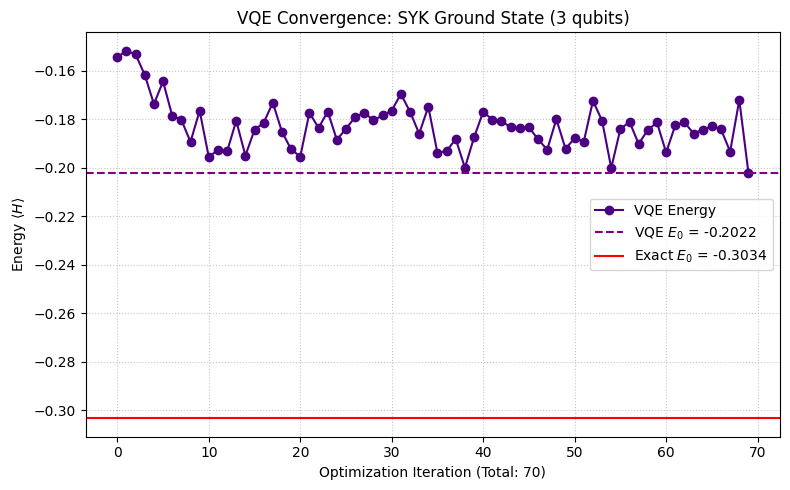


--- Level Spacing Statistics Analysis ---


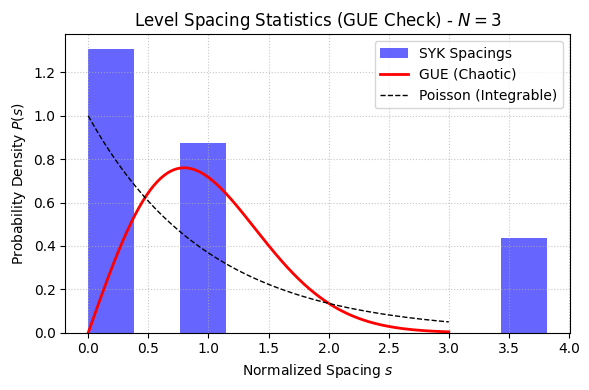

In [3]:
# =================================================================
# SYK CFT Comprehensive Analysis: E0, S2, and Chaos Verification
#
# Goals:
# 1. Find ground state E0 (VQE) and Renyi Entropy S2 (SWAP-Test).
# 2. Verify Quantum Chaos via Level Spacing Statistics (GUE).
# =================================================================
!pip install -U qiskit qiskit-aer pylatexenc matplotlib scipy


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from itertools import combinations
from math import log2

from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit_aer.primitives import Estimator as LocalEstimator
from qiskit_aer.primitives import Sampler as LocalSampler


# ==============================
# 1. Generate SYK Hamiltonian
# ==============================
def majorana_to_pauli(i, n_qubits):
    """Map Majorana index i (0 to 2*n_qubits - 1) to Pauli string."""
    qubit = i // 2
    if i % 2 == 0:
        pauli = ['I'] * n_qubits
        for k in range(qubit):
            pauli[k] = 'Z'
        pauli[qubit] = 'X'
    else:
        pauli = ['I'] * n_qubits
        for k in range(qubit):
            pauli[k] = 'Z'
        pauli[qubit] = 'Y'
    return ''.join(pauli)


def generate_syk_hamiltonian(n_qubits=3, J=1.0, seed=42):
    np.random.seed(seed)
    n_majorana = 2 * n_qubits
    pauli_list = []
    coeff_list = []

    # q=4 SYK Hamiltonian: H ~ sum J_{ijkl} gamma_i gamma_j gamma_k gamma_l
    for i, j, k, l in combinations(range(n_majorana), 4):
        Jijkl = np.random.normal(0, J / (n_majorana ** 1.5))

        p_i = majorana_to_pauli(i, n_qubits)
        p_j = majorana_to_pauli(j, n_qubits)
        p_k = majorana_to_pauli(k, n_qubits)
        p_l = majorana_to_pauli(l, n_qubits)

        term = (
            SparsePauliOp(p_i) @ SparsePauliOp(p_j) @
            SparsePauliOp(p_k) @ SparsePauliOp(p_l)
        ).simplify()

        for pauli, coeff in zip(term.paulis, term.coeffs):
            if abs(coeff) > 1e-15:
                pauli_list.append(str(pauli))
                coeff_list.append(Jijkl * coeff.real)

    H = SparsePauliOp(pauli_list, coeff_list).simplify()

    # Also return the full list of eigenvalues for chaos analysis
    # FIX: Use H.to_matrix(sparse=False) which is the most stable way to get a dense NumPy matrix.
    H_matrix = H.to_matrix(sparse=False)

    # Use eigvalsh for hermitian matrix for stability
    eigvals = np.linalg.eigvalsh(H_matrix)

    return H, np.sort(eigvals)


# ==============================
# 2. VQE Optimization Function
# ==============================
def vqe_runtime(H, ansatz, initial_params=None):
    if initial_params is None:
        initial_params = np.random.uniform(0, 2 * np.pi, ansatz.num_parameters)

    energy_history = []

    def cost(params):
        """The quantum part: calculates the energy expectation value."""
        estimator = LocalEstimator()
        job = estimator.run(circuits=[ansatz], observables=[H], parameter_values=[params])
        return job.result().values[0]

    def callback(xk):
        """The classical part: tracks energy after each optimization step."""
        current_energy = cost(xk)
        energy_history.append(current_energy)

    result = minimize(
        cost,
        initial_params,
        method='COBYLA',
        options={'maxiter': 300, 'disp': False},
        callback=callback
    )

    if result.success and not np.isclose(result.fun, energy_history[-1] if energy_history else 0):
        energy_history.append(result.fun)

    return result, energy_history

# ==============================
# 3. Renyi Entropy SWAP-Test
# ==============================
def calculate_renyi_entropy(ansatz, optimal_params, subregion_A_qubits):
    """Calculates the Purity (Tr(rho_A^2)) using the Controlled-SWAP test."""
    n_qubits = ansatz.num_qubits
    n_copies = 2 * n_qubits + 1

    qc = QuantumCircuit(n_copies, 1)
    ancilla_qubit = n_copies - 1

    psi0_copy1 = ansatz.assign_parameters(optimal_params).to_instruction()
    psi0_copy2 = psi0_copy1.copy()

    # Prepare two copies of the ground state
    qc.append(psi0_copy1, range(n_qubits))
    qc.append(psi0_copy2, range(n_qubits, 2 * n_qubits))
    qc.barrier()

    # Controlled-SWAP Test Core Logic
    qc.h(ancilla_qubit)

    # CSWAP only on qubits in subregion A
    for q_A in subregion_A_qubits:
        q_A_copy2 = q_A + n_qubits
        qc.cswap(ancilla_qubit, q_A, q_A_copy2)

    qc.h(ancilla_qubit)
    qc.measure(ancilla_qubit, 0)

    sampler = LocalSampler()
    job = sampler.run(qc, shots=4096)
    counts = job.result().quasi_dists[0]
    prob_0 = counts.get(0, 0)

    # Purity: Tr(rho_A^2) = 2 * P(0) - 1
    purity_A = 2 * prob_0 - 1

    # Renyi Entropy S_2: S_2 = -log2(Tr(rho_A^2))
    purity_A = max(1e-10, purity_A)
    S2_renyi = -log2(purity_A)

    return S2_renyi, purity_A, qc

# ==============================
# 4. Level Spacing Analysis (Chaos Check)
# ==============================
def plot_level_statistics(eigvals, n_qubits):
    """
    Calculates and plots the normalized level spacing distribution.
    A chaotic system (like SYK) should follow the GUE distribution.
    """
    # Exclude the first few eigenvalues (which might not be in the bulk)
    # For small systems, we typically use all levels except maybe the ground state.
    # Let's take levels 5% to 95% to focus on the bulk.
    start_index = int(len(eigvals) * 0.05)
    end_index = int(len(eigvals) * 0.95)

    # Use the bulk eigenvalues
    bulk_eigvals = eigvals[start_index:end_index]

    spacings = np.diff(bulk_eigvals)

    if len(spacings) < 5:
        print(f"Warning: Only {len(spacings)} spacings available. Plotting may be unreliable.")
        return

    # Normalize spacings to unit mean
    spacings /= np.mean(spacings)

    plt.figure(figsize=(6, 4))

    # Plot histogram of spacings
    hist, bins, _ = plt.hist(spacings, bins=10, density=True, alpha=0.6, color='blue', label='SYK Spacings')

    # Plot Wigner-Dyson (GUE) distribution (Chaotic)
    x = np.linspace(0, 3, 200)
    # P_GUE(s) = (pi/2) * s * exp(-pi*s^2/4) -- Wigner Surmise for GUE
    gue_pdf = (np.pi/2) * x * np.exp(-np.pi * x**2 / 4)
    plt.plot(x, gue_pdf, 'r-', linewidth=2, label='GUE (Chaotic)')

    # Plot Poisson distribution (Integrable/Non-Chaotic)
    poisson_pdf = np.exp(-x)
    plt.plot(x, poisson_pdf, 'k--', linewidth=1, label='Poisson (Integrable)')

    plt.title(f"Level Spacing Statistics (GUE Check) - $N={n_qubits}$")
    plt.xlabel("Normalized Spacing $s$")
    plt.ylabel("Probability Density $P(s)$")
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()


# ==============================
# 5. Full Pipeline Execution
# ==============================
# --- SYK Setup ---
n_qubits = 3
H, eigvals = generate_syk_hamiltonian(n_qubits=n_qubits, J=1.0, seed=42)

# --- VQE Setup ---
ansatz = TwoLocal(
    n_qubits,
    rotation_blocks=['ry', 'rz'],
    entanglement_blocks='cz',
    reps=2,
    entanglement='linear'
)

# --- Run VQE ---
print(f"--- VQE Optimization Started ({ansatz.num_parameters} params) ---")
print(f"Exact Ground State E0 (from diagonalization): {eigvals[0]:.6f}")

result, history = vqe_runtime(H, ansatz)
optimal_E0 = result.fun
optimal_params = result.x
print(f"VQE Optimal Energy (E0): {optimal_E0:.6f}")
print(f"Optimization Success: {result.success}")

# --- Run Renyi Entropy ---
subregion_A = [0, 1]
print(f"\n--- Renyi Entropy Calculation (SWAP-Test) ---")

S2, purity, swap_circuit = calculate_renyi_entropy(ansatz, optimal_params, subregion_A)

print(f"Calculated Purity Tr(rho_A^2): {purity:.6f}")
print(f"Renyi Entropy S2: {S2:.6f}")


# ==============================
# 6. Final Plotting and Verification
# ==============================

# 6.1 VQE Convergence Plot
plt.figure(figsize=(8, 5))
plt.plot(history, marker='o', linestyle='-', color='indigo', label='VQE Energy')
plt.axhline(optimal_E0, color='purple', linestyle='--', label=f"VQE $E_0$ = {optimal_E0:.4f}")
plt.axhline(eigvals[0], color='red', linestyle='-', label=f"Exact $E_0$ = {eigvals[0]:.4f}")
plt.title(f"VQE Convergence: SYK Ground State ({n_qubits} qubits)")
plt.ylabel("Energy $\\langle H \\rangle$")
plt.xlabel(f"Optimization Iteration (Total: {len(history)})")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()


# 6.2 Level Spacing Statistics Plot (Chaos Verification)
print("\n--- Level Spacing Statistics Analysis ---")
plot_level_statistics(eigvals, n_qubits)
